# Proyecto Toma de decisiones de negocios basadas en datos

Eres analista en una gran tienda en línea. Junto con el departamento de marketing has recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos. El objetivo del proyecto es priorizar estas hipótesis, lanzar un test A/B y analizar los resultados.

## Tabla de contenidos <a id='back'></a>

* [Inicialización](#intro)
* [Descarga de datos y preparación](#descarga_preparación)
* [Priorizar hipótesis](#parte_1)
* [Análisis del test A/B](#parte_2)

## Inicialización <a id='intro'></a>

Para iniciar nuestro proyecto vamos a cargar nuestras librerias

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

## Descarga de datos y preparación <a id='descarga_preparación'></a>

Vamos a cargar los datos de 3 dataset `hypotheses_us.csv`, `orders_us.csv` y `data/visits_us.csv`

In [2]:
# Carga los archivos de datos
data_hypotheses = pd.read_csv('data/hypotheses_us.csv', sep=';')
data_orders = pd.read_csv('data/orders_us.csv')
data_visits = pd.read_csv('data/visits_us.csv')

In [3]:
# Verificamos que los datos se hayan cargado correctamente
print(data_hypotheses.head())
print()
print(data_orders.head())
print()
print(data_visits.head())

                                          Hypothesis  Reach  Impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   

   Confidence  Effort  
0           8       6  
1           4      10  
2           7       3  
3           3       8  
4           1       1  

   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     30.4     B
1     2804400009  3642806036  2019-08-15     15.2     B
2     2961555356  4069496402  2019-08-15     10.2     A
3     3797467345  1196621759  2019-08-15    155.1     B
4     2282983706  2322279887  2019-08-15     40.5     B

         date group  visits
0  2019-08-01     A     719
1  2019-08-02     A     619
2  2019

Vamos a estudiar los datos que contienen nuestros datasets y verificar que los tipos de datos sean correctos para nuestro análisis

In [4]:
# Imprimimos la información general/resumen sobre nuestro primer dataset
data_hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
# Se imprime una muestra de los datos
data_hypotheses.head()

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


El primer dataset `data_hypotheses` que son los datos de las hipotesis que se quieren explorar con sus respectivas calificaciones, contiene los siguientes datos:

- `Hypotheses`: breves descripciones de las hipótesis
- `Reach`: alcance del usuario, en una escala del uno a diez
- `Impact`: impacto en los usuarios, en una escala del uno al diez
- `Confidence`: confianza en la hipótesis, en una escala del uno al diez
- `Effort`: los recursos necesarios para probar una hipótesis, en una escala del uno al diez. Cuanto mayor sea el valor Effort, más recursos requiere la prueba.

In [6]:
# Verificamos que no haya datos duplicados en el dataset
print('Datos duplicados en el dataset:', data_hypotheses.duplicated().sum())

Datos duplicados en el dataset: 0


#### Conclusiones del primer dataset

Al ver la muestra y resumen del dataset, no encontramos datos faltantes ni duplicados. No presenta optimizaciones extra que podamos hacer, solamente se renombraran las columnas haciendo uso de snake_case para mejor manejo. Tambien hay que mencionar que debido a la naturaleza de los datos númericos, no fue necesario ver una descripción de ellos.

Pasamos al segundo dataset

In [7]:
# Imprimimos la información general/resumen sobre nuestro segundo dataset
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [8]:
# Se imprime una muestra de los datos
data_orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


El segundo dataset `data_orders` que son los datos sobre pedidos, contiene los siguientes datos:

- `transactionId`: identificador de pedido
- `visitorId`: identificador del usuario que realizó el pedido
- `date`: fecha del pedido
- `revenue`: ingresos del pedido
- `group`: el grupo del test A/B al que pertenece el usuario.

In [9]:
# Se imprime una descripción de los datos
data_orders['revenue'].describe()

count     1197.000000
mean       131.491646
std        603.004729
min          5.000000
25%         20.800000
50%         50.200000
75%        130.400000
max      19920.400000
Name: revenue, dtype: float64

In [10]:
# Verificamos que no haya datos duplicados en el dataset
print('Datos duplicados en el dataset:', data_orders.duplicated().sum())

Datos duplicados en el dataset: 0


#### Conclusiones del segundo dataset

Al ver la muestra y resumen del dataset no encontramos datos faltantes ni duplicados, sin embargo debemos pasar los datos de la columna `date` a fecha. Tambien al ver la descripción de los datos numéricos vemos que la media de los ingresos es más del doble que el de la mediana, además de que el 75% de los datos no llega a superar los $130, todo esto nos indica la presencia de valores outliers

Pasemos al 3er dataset

In [11]:
# Imprimimos la información general/resumen sobre el 3er dataset
data_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
# Se imprime una muestra de los datos
data_visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


El tercer dataset `data_visits` que son los datos sobre las visitas de la página, contiene los siguientes datos:

- `date`: la fecha
- `group`: grupo del test A/B
- `visits`: el número de visitas en la fecha especificada para el grupo de test A/B especificado

In [13]:
# Se imprime una descripción de los datos
data_visits.describe()

,visits
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [14]:
# Verificamos que no haya datos duplicados en el dataset
print('Datos duplicados en el dataset:', data_visits.duplicated().sum())

Datos duplicados en el dataset: 0


#### Conclusiones del tercer dataset

Al ver la muestra y resumen del dataset no encontramos datos faltantes ni duplicados, sin embargo debemos pasar los datos de la columna `date` a fecha. Tambien al ver la descripción de los datos numéricos no notamos ningún indicio de valores outliers

### Corregir datos

#### Primer dataset

Vamos a pasar los nombres de las columnas a snake_case

In [15]:
# Renombrar las columnas con snake_case
data_hypotheses.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'effort']
# Verificamos el cambio
data_hypotheses.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'effort'], dtype='object')

#### Segundo dataset

Vamos a pasar la columna `date` a fecha y la columna `group` a categoria. Además, se pasaran los nombres de las columnas a snake_case

In [16]:
# Pasamos date a fecha
data_orders['date'] =  pd.to_datetime(data_orders['date'], format="%Y.%m.%d")

# Verificamos los cambios
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [17]:
# Pasamos los nombres a snake_case
data_orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
data_orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

#### Tercer dataset

Vamos a pasar la columna `date` a fecha y la columna `group` a categoria.

In [18]:
# Pasamos date a fecha
data_visits['date'] =  pd.to_datetime(data_visits['date'], format="%Y.%m.%d")

# Verificamos los cambios
data_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Con estas correcciones, nuestros dataset estan listos para nuestro análisis.

## Priorizar hipótesis <a id='parte_1'></a>

Nuestra tabla `data_hypotheses` contiene 9 hipótesis sobre cómo aumentar los ingresos de una tienda en línea.

Debemos:

- Aplicar el framework `ICE` para priorizar hipótesis. Ordenarlas en orden descendente de prioridad.
- Aplicar el framework `RICE` para priorizar hipótesis. Ordenarlas en orden descendente de prioridad.
- Mostrar cómo cambia la priorización de hipótesis cuando utilizas `RICE` en lugar de `ICE`. Proporcionar una explicación de los cambios.

Primero empezaremos con el framework `ICE`. En este framework debemos tomar en cuenta el impacto, confianza y esfuerzo para cada una de las hipotesis

In [19]:
# Vemos una muestra de los datos
data_hypotheses.head()

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [20]:
# Creamos la columna ICE para realizar el calculo para cada una de las hipotesis
data_hypotheses['ICE'] = (data_hypotheses['impact'] *
                          data_hypotheses['confidence']) / data_hypotheses.effort

data_hypotheses[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


Podemos ver que las hipótesis con indice 8 (promoción de descuento en cumpleaños), indice 0 (Agregar 2 canales nuevos para atraer más tráfico) e indice 7 (Agregar un formato de suscripción a todas las páginas principales) son las más prometedoras.

Ahora pasemos al framework RICE. En este framework se toma en cuenta las anteriores métricas pero con el diferencial del alcance.

In [21]:
# Creamos la columna RICE para realizar el calculo para cada una de las hipotesis
data_hypotheses['RICE'] = (data_hypotheses['reach'] * data_hypotheses['impact'] *
                          data_hypotheses['confidence']) / data_hypotheses.effort

data_hypotheses[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


Podemos ver que las hipótesis con índice 0 y 7 vuelven a estar en el top 3 de más prometedoras, sin embargo la hipótesis con índice 8 ha bajado bastante en prioridad, ya que la hipótesis con índice 2 (Agregar bloques con recomendaciones de producto en el sitio de la tienda) ocupa un lugar en el top 3

### Conclusiones intermedias

Como se pudo notar, hubo un cambio en el top 3 de hipótesis prometedoras. Siendo la hipótesis con índice 8 (Lanzar descuentos para usuarios en su cumpleaños) la que quedo fuera. Este cambio es debido que al tomar en cuenta el número de usuarios que vamos a impactar con nuestras hipotesis, tenemos hipótesis que impactaran a una cantidad más significativa de usuarios que en comparación a esta promoción que tiene un valor de uno en este parámetro.

Ya que el objetivo de cualquier negocio es aumentar sus ventas, debemos priorizar impactar al mayor número de personas con nuestras hipotesis por lo que para este caso recomiendo ampliamente considerar el top 3 proporcionado por el framework RICE

## Análisis de test A/B <a id='parte_2'></a>

Se realizo un test A/B y se obtuvieron resultados contenidos en nuestras tablas `data_orders` y `data_visits`

Debemos:

- Representar gráficamente el ingreso acumulado por grupo. Sacar conclusiones y hacer conjeturas.
- Representar gráficamente el tamaño de pedido promedio acumulado por grupo. Sacar conclusiones y hacer conjeturas.
- Representar gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A. Sacar conclusiones y hacer conjeturas.
- Calcular la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representar gráficamente las tasas de conversión diarias de los dos grupos y describir la diferencia. Sacar conclusiones y hacer conjeturas.
- Trazar un gráfico de dispersión del número de pedidos por usuario. Sacar conclusiones y hacer conjeturas.
- Calcular los percentiles 95 y 99 para el número de pedidos por usuario. Definir el punto en el cual un punto de datos se convierte en una anomalía.
- Trazar un gráfico de dispersión de los precios de los pedidos. Sacar conclusiones y hacer conjeturas.
- Calcular los percentiles 95 y 99 de los precios de los pedidos. Definir el punto en el cual un punto de datos se convierte en una anomalía.
- Encontrar la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto. Sacar conclusiones y hacer conjeturas.
- Encontrar la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto. Sacar conclusiones y hacer conjeturas.
- Encontrar la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. Sacar conclusiones y hacer conjeturas.
- Encontrar la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. Sacar conclusiones y hacer conjeturas.
- Se debe tomar una decisión basada en los resultados de la prueba. Las decisiones posibles son:
  1. Para la prueba, considera a uno de los grupos como líder.
  2. Para la prueba, concluye que no hay diferencia entre los grupos.
  3. Continúa la prueba.

Antes de iniciar con nuestro análisis, debemos verificar que cada visitante esten solo en un grupo (A o B). Para esto agruparemos por visitante y contaremos sus datos unicos de grupo, si hay alguno con 2, se tomara en cuenta para la prueba el primer grupo en el que entro.

In [22]:
# Verificamos el dataset de ordenes
visitors_two_groups = data_orders.groupby('visitor_id')['group'].nunique().reset_index().query('group > 1')
visitors_two_groups

,visitor_id,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2
84,351125977,2
97,393266494,2
114,457167155,2
119,471551937,2
122,477780734,2


Como podemos observar, tenemos 58 visitantes que estan en 2 grupos del test, debemos corregirlo.

In [23]:
# Seleccionamos los id's de los visitantes con doble grupo
visitors_two_groups = visitors_two_groups['visitor_id']

# De la tabla orders seleccionamos para los visitantes identificados sus grupos y fechas
orders_two_groups = data_orders.loc[data_orders['visitor_id'].isin(visitors_two_groups)]
orders_two_groups

,transaction_id,visitor_id,date,revenue,group
2,2961555356,4069496402,2019-08-15,10.2,A
20,2904772834,963407295,2019-08-15,5.6,B
23,4252514150,351125977,2019-08-15,235.6,B
24,1162046357,3234906277,2019-08-15,120.2,B
26,2223239646,199603092,2019-08-15,55.7,A
...,...,...,...,...,...
1182,2682156369,1668030113,2019-08-14,20.8,B
1183,1458356232,963407295,2019-08-14,80.0,A
1184,1329499668,2949041841,2019-08-14,160.7,B
1189,4082620617,393266494,2019-08-14,490.4,B


In [24]:
# Generamos las primeras fechas de esos visitantes
dates_two_groups = orders_two_groups.groupby(['visitor_id']).agg({'date': min})

# Unimos al dataset de fechas el dataset con los grupos para solo quedarnos con los grupos de la primera fecha
final_two_groups = pd.merge(dates_two_groups, orders_two_groups, on=['visitor_id', 'date'], how='inner')
final_two_groups

,visitor_id,date,transaction_id,revenue,group
0,8300375,2019-08-01,3679129301,165.7,B
1,199603092,2019-08-02,437656952,55.7,B
2,232979603,2019-08-31,2670069237,45.6,B
3,232979603,2019-08-31,83566152,5.9,A
4,237748145,2019-08-12,3357467820,10.2,A
...,...,...,...,...,...
73,4120364173,2019-08-29,4212256267,615.3,A
74,4186807279,2019-08-14,3757656646,80.8,A
75,4256040402,2019-08-01,1120327437,90.2,A
76,4266935830,2019-08-29,1811671147,1220.2,A


In [25]:
# Verificamos que ya no haya doble grupo
visitors_two_groups_final = final_two_groups.groupby('visitor_id')['group'].nunique().reset_index().query('group > 1')
visitors_two_groups_final

,visitor_id,group
2,232979603,2
9,477780734,2
12,1230306981,2
14,1316129916,2
22,1801183820,2
24,2038680547,2
28,2579882178,2
32,2686716486,2
37,2949041841,2
40,3202540741,2


Podemos ver que aun tenemos 15 visitantes con 2 grupos, este se debe a que estas personas ingresaron el mismo dia a los 2 grupos y no pudimos identificar primer grupo. Debido a esto eliminaremos estos usuarios del dataset

In [26]:
# Eliminamos los datos que identificamos al principio
data_orders_1 = data_orders[~data_orders['visitor_id'].isin(visitors_two_groups)]

# Filtramos nuestros datos de visitantes con 2 grupos el mismo dia
final_two_groups = final_two_groups[~final_two_groups['visitor_id'].isin(visitors_two_groups_final['visitor_id'])].reset_index(drop=True)

# Agregamos los datos con un solo grupo
data_orders_filtered = pd.concat([data_orders_1, final_two_groups])

# Verificamos que no haya visitantes con 2 grupos
print('Numero de visitantes con 2 grupos:', data_orders_filtered.groupby('visitor_id')['group'].nunique().reset_index().query('group > 1').shape[0])
print('Tamaño del dataset orders original:', data_orders.shape[0])
print('Tamaño del dataset orders filtrado:', data_orders_filtered.shape[0])

Numero de visitantes con 2 grupos: 0
Tamaño del dataset orders original: 1197
Tamaño del dataset orders filtrado: 1060


Una vez realizado este paso, nuestro dataset esta libre de errores y listo para ser analizado

### Representar gráficamente el ingreso acumulado por grupo.

In [27]:
# Crear una matriz con valores únicos de parejas fecha-grupo
dates_groups = data_orders_filtered[['date','group']].drop_duplicates()
dates_groups

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [28]:
# Obtenemos los datos diarios acumulados agregados sobre los pedidos
orders_aggregated = dates_groups.apply(lambda x: data_orders_filtered[np.logical_and(data_orders_filtered['date'] <= x['date'], data_orders_filtered['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique, 'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

orders_aggregated

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,2356.8
66,2019-08-01,B,21,20,1620.0
175,2019-08-02,A,43,37,3825.1
173,2019-08-02,B,45,43,4243.8
291,2019-08-03,A,67,61,5640.3
...,...,...,...,...,...
533,2019-08-29,B,534,513,77153.6
757,2019-08-30,A,480,457,55150.1
690,2019-08-30,B,555,534,80440.4
958,2019-08-31,A,488,465,55998.4


In [29]:
# Obtenemos los datos diarios acumulados agregados sobre las visitas
visitors_aggregated = dates_groups.apply(lambda x: data_visits[np.logical_and(data_visits['date'] <= x['date'], data_visits['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitors_aggregated

,date,group,visits
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
533,2019-08-29,B,17708
757,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [30]:
#  fusiona las dos tablas en una y da a sus columnas nombres descriptivos
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,2356.8,719
1,2019-08-01,B,21,20,1620.0,713
2,2019-08-02,A,43,37,3825.1,1338
3,2019-08-02,B,45,43,4243.8,1294
4,2019-08-03,A,67,61,5640.3,1845
...,...,...,...,...,...,...
57,2019-08-29,B,534,513,77153.6,17708
58,2019-08-30,A,480,457,55150.1,18037
59,2019-08-30,B,555,534,80440.4,18198
60,2019-08-31,A,488,465,55998.4,18736


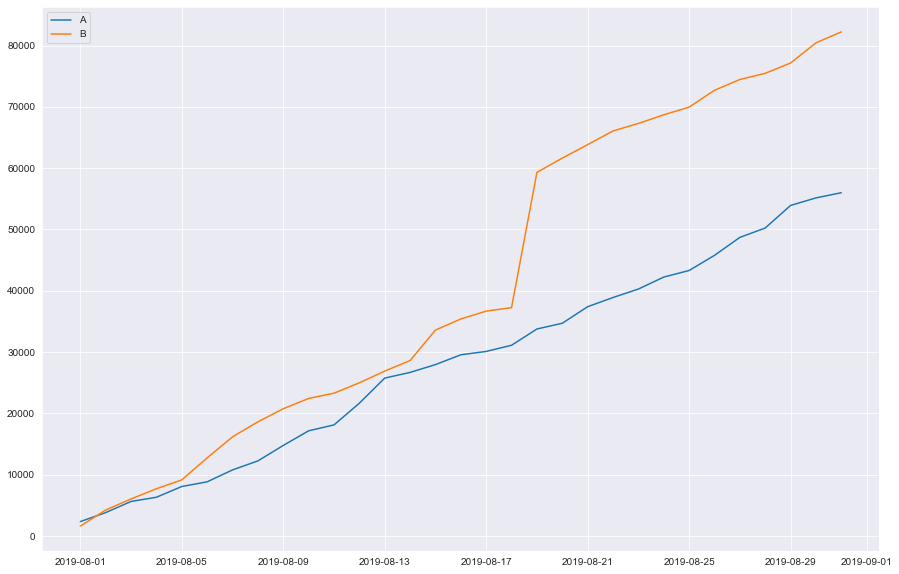

In [31]:
# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo A
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Ajustamos el tamaño de la figura
plt.figure(figsize=(15,10))

# Trazar el gráfico de ingresos del grupo A
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Trazar el gráfico de ingresos del grupo B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.legend()

#### Conclusiones ingreso acumulado por grupo

Los ingresos aumentan constantemente durante toda la prueba. Sin embargo, podemos notar que el grupo B tiene un aumento abrupto en cierto punto para luego asentarse en ese aumento, esto hace que se diferencie completamente del grupo A y tengo mayor ingreso.

Esta situación puede indicar la presencia de pedidos muy caros en la muestra o un aumento abrupto de pedidos, se debe analizar estos datos atípicos

### Representar gráficamente el tamaño de pedido promedio acumulado por grupo.

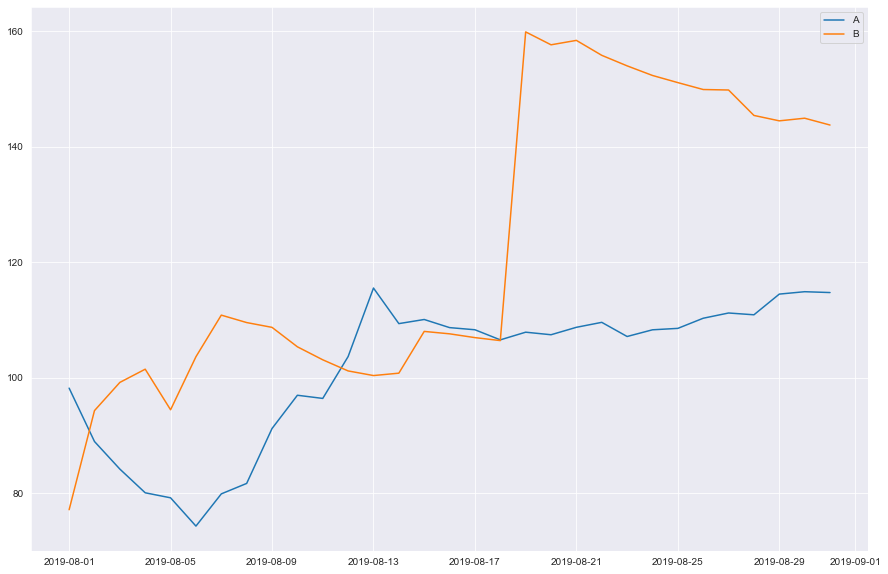

In [32]:
# Ajustamos el tamaño de la figura
plt.figure(figsize=(15,10))

# Dividimos los ingresos acumulados entre el número acumulado de pedidos
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.legend()

#### Conclusiones tamaño de pedido promedio acumulado por grupo

Podemos observar que en el tamaño de pedido promedio hay picos de subida, sin embago podemos notar que para el grupo b hubo un aumento abrupto a los 160 pedidos, este en vez de mantenerse procedio rapidamente a descender, mientras que el grupo A sigue aumentando constantemente. Esto nos puede indicar con mayor claridad que hay datos atipicos que debemos tratar para conocer el verdadero tamaño promedio de los pedidos.

### Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A.

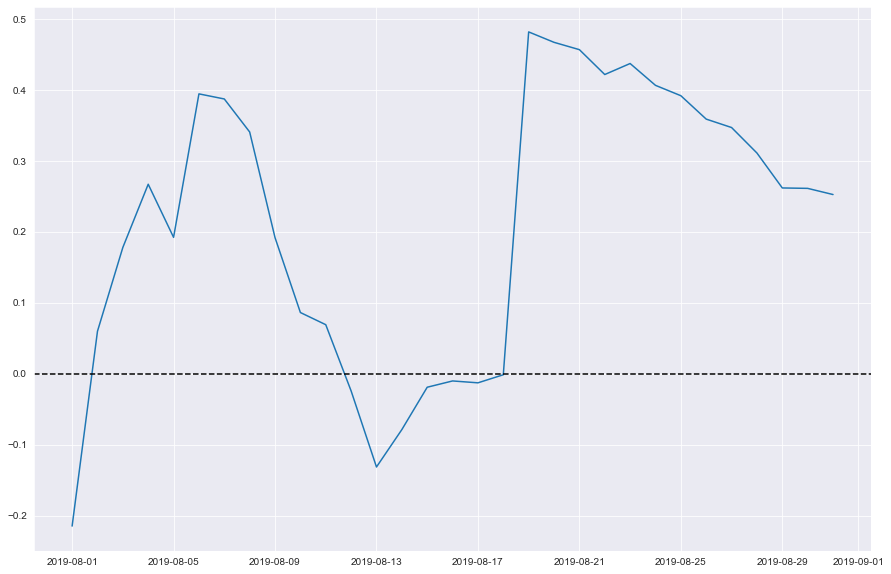

In [33]:
# Reunir los datos en un DataFrame
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# Ajustamos el tamaño de la figura
plt.figure(figsize=(15,10))

# Trazar un gráfico de diferencia relativa para los tamaños de pedido promedio acumulado
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# Agregar el eje X
plt.axhline(y=0, color='black', linestyle='--')

#### Conclusiones diferencia relativa en el tamaño de pedido promedio acumulado del grupo B vs grupo A

Podemos observar que en varios puntos la diferencia entre segmentos es bastante significativa, casi un 0.5! Esto nos da más certeza en asegurar que tenemos datos atípicos y pedidos grandes en nuestras muestras.

### Tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representación gráfica de las tasas de conversión diarias de los dos grupos y describe la diferencia.

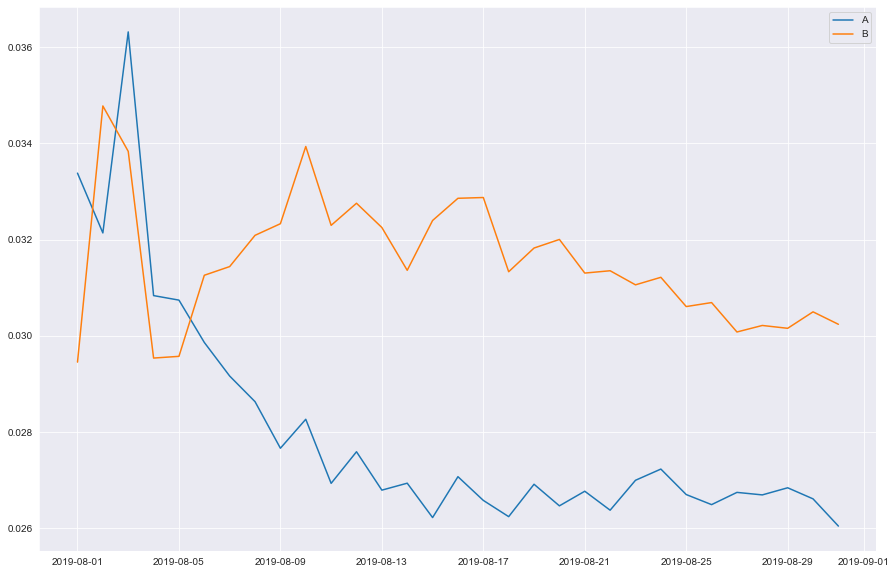

In [34]:
# Calculamos la conversión acumulada
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# Seleccionar datos en el grupo A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# Seleccionar datos en el grupo B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# Ajustamos el tamaño de la figura
plt.figure(figsize=(15,10))

# Trazar los gráficos
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()

#### Conclusiones tasa de conversión por grupo

Como podemos observar en la gráfica, los grupos iban relativamente parejos pero en los primeros dias el grupo A presento caidas importantes en la tasa de conversión y su caida a sido continua a lo largo de toda la prueba. Por otro lado, el grupo B tuvo subidas y bajadas continuas pero a mitades de la prueba su tasa de conversion empezo a bajar hasta establecerse cerca de los 0.030.

Esta situación parece indicar que el grupo B esta teniendo mejor tasa de conversión que el grupo A, aunque ambos grupos estan teniendo dificultades para establecerse.

### Traza un gráfico de dispersión del número de pedidos por usuario.

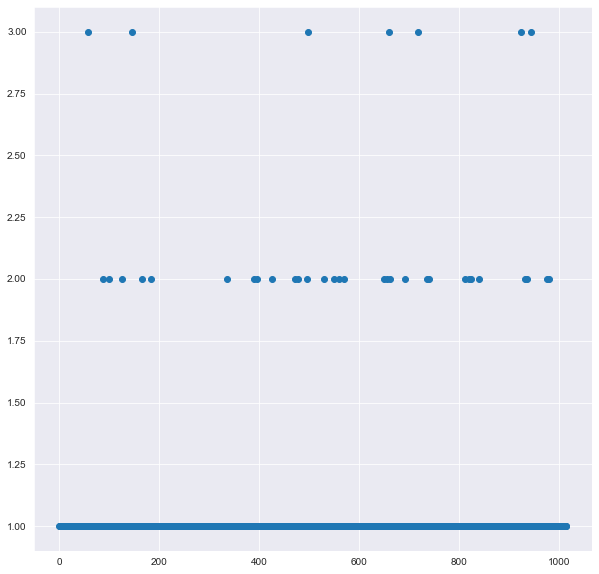

In [35]:
# Generamos las ordenes por usuario
orders_by_users = (
    data_orders_filtered.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

orders_by_users.columns = ['visitor_id', 'orders']

# Ajustamos el tamaño de la figura
plt.figure(figsize=(10,10))

# Trazar el gráfico de dispersión
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders'])

#### Conclusiones dispersión de número de pedidos por usuario

Podemos observar en la gráfica que la mayoria de usuarios piden solo un pedido mientras que muy pocos llegan a pedir 2 y aun menos usuarios llegan a pedir 3. Claramente, hay datos atípicos que debemos tratar

### Percentiles 95 y 99 para el número de pedidos por usuario. Definir el punto en el cual un punto de datos se convierte en una anomalía.

In [36]:
print('Percentil 90:', int(np.percentile(orders_by_users['orders'], [90])))
print('Percentil 95:', int(np.percentile(orders_by_users['orders'], [95])))
print('Percentil 99:', int(np.percentile(orders_by_users['orders'], [99])))


Percentil 90: 1
Percentil 95: 1
Percentil 99: 2


#### Conclusiones percentiles 95 y 99 para el número de pedidos por usuario.

Podemos observar que no más del 1% de los usuarios realizan más de 2 pedidos. Teniendo esto en cuenta, estableceremos que los usuarios con más de 1 pedido seran considerados anómalias y se filtraran

### Traza un gráfico de dispersión de los precios de los pedidos.

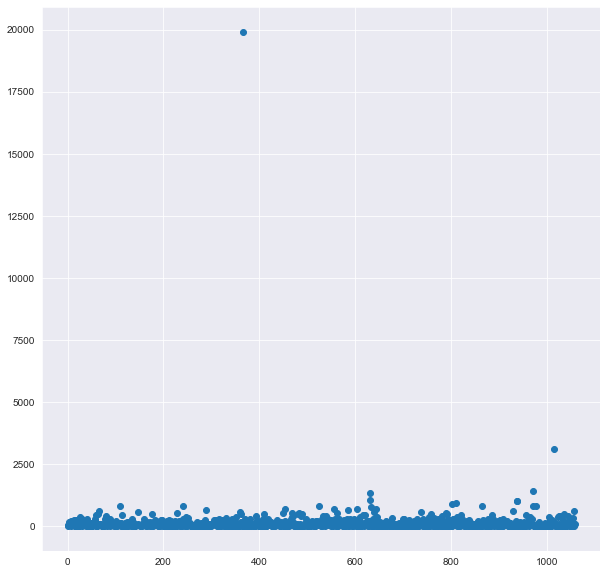

In [37]:
# Ajustamos el tamaño de la figura
plt.figure(figsize=(10,10))

# Trazamos el gráfico
x_values = pd.Series(range(0, len(data_orders_filtered['revenue'])))
plt.scatter(x_values, data_orders_filtered['revenue'])

#### Conclusiones dispersión de los precios de los pedidos

Podemos observar en la gráfica que casi todos los pedidos son menores a 2500, mientas que identificamos 2 pedidos grandes en la muestra (1 de ellos de 20,000), claramente son datos anormales.

### Percentiles 95 y 99 de los precios de los pedidos. Definir el punto en el cual un punto de datos se convierte en una anomalía.

In [38]:
print('Percentil 90:', int(np.percentile(data_orders_filtered['revenue'], [90])))
print('Percentil 95:', int(np.percentile(data_orders_filtered['revenue'], [95])))
print('Percentil 99:', int(np.percentile(data_orders_filtered['revenue'], [99])))

Percentil 90: 280
Percentil 95: 425
Percentil 99: 830


#### Conclusiones percentiles 95 y 99 de los precios de los

Podemos observar que no más del 5% de los pedidos cuestan más de 425 y no más del 1% cuestan más de 830. Con la información anterior, estableceremos que todos los pedidos por encima de los 830 sera considerado anomalo.


### Encontrar la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto.

In [39]:
# Pedidos por usuario del grupo A
orders_by_users_a = data_orders_filtered[data_orders_filtered['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
orders_by_users_a.columns = ['userId', 'orders']

# Pedidos por usuario del grupo B
orders_by_users_b = data_orders_filtered[data_orders_filtered['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
orders_by_users_b.columns = ['userId', 'orders']

# Creacion de la muestra A
sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(data_visits[data_visits['group']=='A']['visits'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

# Creacion de la muestra B
sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(data_visits[data_visits['group']=='B']['visits'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)

# Diferencia de la conversión entre los grupos A y B
print("{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print("{0:.3f}".format(sample_b.mean()/sample_a.mean()-1))

0.010
0.161


#### Conclusiones significancia estadística de la diferencia en la conversión entre los grupos con datos en bruto

Podemos observar por el primer dato, que el valor de p nos dio 0.010, esto es mayor a nuestro nivel de significancia general que es de 0.05. Esto nos indica que no hay diferencia significativa en la conversión de los grupos. Sin embargo, el grupo B tiene una ganancia relativa de 16.1%.

Comparando estos resultados con los de la grafica podemos observar que aunque se notaba una diferencia bastante clara, estadisticamente hablando no es significativa.

### Encontrar la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto.

In [40]:
# Diferencia del tamaño promedio de pedido entre los grupos A y B
print('{0:.3f}'.format(stats.mannwhitneyu(data_orders_filtered[data_orders_filtered['group']=='A']['revenue'], data_orders_filtered[data_orders_filtered['group']=='B']['revenue'])[1]))

print('{0:.3f}'.format(data_orders_filtered[data_orders_filtered['group']=='B']['revenue'].mean()/data_orders_filtered[data_orders_filtered['group']=='A']['revenue'].mean()-1))

0.760
0.253


#### Conclusiones significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos con datos en bruto

Podemos observar que el valor de p (0.760) es bastante superior a nuestro nivel de significancia general que es de 0.05. Esto nos indica que el tamaño promedio de pedidos no difiere significativamente entre los grupos, sin embargo el pedido de B es mucho mayor que el del grupo A por 25.3%

### Encontrar la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados.

In [41]:
# Vamos a indentificar los usuarios anómalos
users_with_many_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders'] > 1]['userId'], orders_by_users_b[orders_by_users_b['orders'] > 1]['userId']], axis = 0)
users_with_expensive_orders = data_orders_filtered[data_orders_filtered['revenue'] > 830]['visitor_id']
users_with_expensive_orders.rename('userId', inplace=True)
abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis = 0).drop_duplicates().sort_values()
print('Usuarios anómalos:', abnormal_users.shape[0])

Usuarios anómalos: 49


In [42]:
# Muestras de los grupos filtradas del número de pedidos por usuario
sample_a_filtered = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['userId'].isin(abnormal_users))]['orders'],pd.Series(0, index=np.arange(data_visits[data_visits['group']=='A']['visits'].sum() - len(orders_by_users_a['orders'])),name='orders')],axis=0)

sample_b_filtered = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['userId'].isin(abnormal_users))]['orders'],pd.Series(0, index=np.arange(data_visits[data_visits['group']=='B']['visits'].sum() - len(orders_by_users_b['orders'])),name='orders')],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print("{0:.3f}".format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

0.007
0.186


#### Conclusiones significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados

Una vez filtrados los datos, pudimos observar ya un valor de p (0.007) menor a nuestro nivel de significancia general que es de 0.05. Esto indica que hay una diferencia significativa en nuestras muestras y que el grupo B tiene una ganancia relativa al 18.6%.

Los datos anomalos estaban afectando los resultados de nuestra prueba y fue un gran acierto quitarlos, ya que antes de ello no se encontraba una diferencia significativa

### Encontrar la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados.

In [43]:
print('{0:.3f}'.format(stats.mannwhitneyu(
    data_orders_filtered[np.logical_and(
        data_orders_filtered['group']=='A',
        np.logical_not(data_orders_filtered['visitor_id'].isin(abnormal_users)))]['revenue'],
    data_orders_filtered[np.logical_and(
        data_orders_filtered['group']=='B',
        np.logical_not(data_orders_filtered['visitor_id'].isin(abnormal_users)))]['revenue'])[1]))

print('{0:.3f}'.format(
    data_orders_filtered[np.logical_and(data_orders_filtered['group']=='B',np.logical_not(data_orders_filtered['visitor_id'].isin(abnormal_users)))]['revenue'].mean()/
    data_orders_filtered[np.logical_and(
        data_orders_filtered['group']=='A',
        np.logical_not(data_orders_filtered['visitor_id'].isin(abnormal_users)))]['revenue'].mean() - 1))

0.901
0.003


#### Conclusiones significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados

Los resultados reflejan que el valor de p aumento aun más, demostrando que no hay una diferencia significativa entre las muestras y esto se refleja aun más en la diferencia relativa en los segmentos pasando de un 25.3% a un 0.3%.

Claramente tambien en este caso las anomalias estaban afectando los resultados y dando a entender diferencias relativas más grandes de lo real

### Toma una decisión basada en los resultados de la prueba.

- Se encontro una diferencia significativa entre las conversiones de los grupos, siendo esta una diferencia relativa del 18.6%. Tambien tomando en cuenta la gráfica, podemos ver que ambos grupos tienen problemas para matenerse estables en la conversión, sin embargo se ve claramente que el grupo B tiene mejor conversión que el grupo A que a lo largo de toda la prueba ha estado cayendo.
- No se encontro una diferencia significativa entre el tamaño promedio de pedidos de los grupos y el grupo B es diminutamente mejor que el grupo A (0.3%). La gráfica parecia demostrar que el grupo B tiene mayor número de compra pero eran datos anomalos alterando los resultados.

Tomando en cuenta lo anterior expuesto, nuestra decisión seria `parar la prueba`, ya que el grupo B en conversión es el claro lider y el grupo A no indica señales de mejorar. Respecto al tamaño del pedido, ambos grupos estan estables y no hay ningun indice que esto vaya a cambiar.